# Microenvironment modeling analysis.

This notebook demonstrates two models to predict the gene expression based on connections between categories within spatial neighborhoods and the cell type-specific expression of ligands and receptors. This is done in the following three steps.

1. Choose gene set for testing: highly spatially autocorrelated genes;
2. Niche model: predict the value of gene expression based on connections between categories within spatial neighborhoods;
3. Niche LR model: predict target gene expression based on the connections between categories within spatial neighborhoods and the cell type-specific expression of ligands and receptors.

In [14]:
import os
import spateo as st
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

## Load data

We will be using a axolotl dataset from [Wei et al., 2022] (https://doi.org/10.1126/science.abp9444).

Here, we can get data directly from the function: 

axolotl_2DPI_ right: `st.sample_data.axolotl_2DPI_right()` 

In [4]:
adata = st.sample_data.axolotl_2DPI_right()
adata

AnnData object with n_obs × n_vars = 3625 × 27324
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'inj_M_L', 'Annotation', 'spec'
    var: 'Axolotl_ID', 'hs_gene'
    uns: 'Annotation_colors', '__type', 'color_key'
    obsm: 'X_pca', 'X_spatial', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

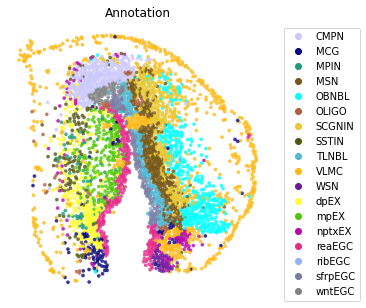

In [5]:
st.pl.space(adata, 
            color=['Annotation'], 
            pointsize=0.2,
            color_key=adata.uns['color_key'],
            show_legend='upper left',
            figsize = (5,5))

In [6]:
#axolotl_2dpi = right

## Selection of genes of interest.

For example, we can choose highly spatially autocorrelated genes, or the genes that we are interested in. 
These potentially reflect signaling patterns that are uniform across spatial domains and have potentially interesting relationships cell-cell interaction events.

In [8]:
# Output directory:
save_dir = './model_result'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Here, we use the `st.tl.moran_i()` to detect the genes that have spatial pattern.

In [10]:
m_degs = st.tl.moran_i(adata)
m_filter = m_degs[(m_degs.moran_i > 0.1) & (m_degs.moran_q_val < 0.05)].sort_values(by=['moran_i'], ascending=False)
m_filter.to_csv(os.path.join(save_dir, 'morani.csv'))

Then, filter down to genes morani >= 0.4 and expressed in at least 5% of cells (you can use different filtering criteria based on your own data).

In [15]:
m_filter = m_filter[m_filter['moran_i'] > 0.4]
n_cells = adata.n_obs
to_keep = []
for gene in m_filter.index:
    adata_sub = adata[:, gene]
    if scipy.sparse.issparse(adata_sub.X):
        n_cells_by_counts = adata_sub.X.getnnz(axis=0)
    else:
        n_cells_by_counts = np.count_nonzero(adata_sub.X, axis=0)
    if n_cells_by_counts >= 0.05 * n_cells:
        to_keep.append(gene)
        
targets = m_filter.loc[to_keep]
targets

,Axolotl_ID,moran_i,moran_p_val,moran_z,moran_q_val
5,AMEX60DD041912,0.702088,0.005,71.204317,0.035357
12,AMEX60DD023492,0.619814,0.005,62.190959,0.035357
26,AMEX60DD038981,0.542571,0.005,56.044881,0.035357
34,AMEX60DDU001033882,0.516351,0.005,55.896494,0.035357
36,AMEX60DDU001010550,0.514014,0.005,150.624811,0.035357
37,AMEX60DD021318,0.512877,0.005,53.106747,0.035357
48,AMEX60DD041078,0.470341,0.005,40.529068,0.035357
50,AMEX60DD016339,0.466396,0.005,48.296279,0.035357
61,AMEX60DD022464,0.437204,0.005,34.854825,0.035357
67,AMEX60DD024109,0.428605,0.005,48.959965,0.035357


(optional) Specific processing of axolotl data, Homologous gene to human.

In [16]:
# Process to human-equivalent gene names(SOD2 maps to two different genes...)
adata = adata[:, adata.var['hs_gene'] != 'SOD2']
adata = adata[:, adata.var['hs_gene'] != "-"]
adata.var_names = adata.var['hs_gene']
targets = adata.var[adata.var['Axolotl_ID'].isin(targets['Axolotl_ID'])].index.tolist()
# here we add gene 'FZD2' to target gene list
targets = targets + ['FZD2']
targets

['AGR2', 'AQP1', 'RTN1', 'FTL', 'SLC1A3', 'SCGN', 'FABP7', 'FZD2']

## Niche model 

Niche model is used to predict the value of gene expression based on connections between categories within spatial neighborhoods. 

Here, we use the target gene above to test our niche model. and assuming that the target gene expression follows a Poisson's distribution(negative binomial and zero-inflated negative binomial are also provided in our function).
Note that the Poisson's distribution generally requires the UMI counts.

Process for Poisson regression

In [19]:
adata.layers['processed_counts'] = adata.X
adata.X = adata.layers['counts']

First, we fit the niche model, return coefficients (some other quantities of interest save to the AnnData object), and reg_lambda: discrete values of lambda regularization parameter to test
n_jobs: number of parallel processes to run (genes to fit on in parallel).

In [22]:
niche_interp = st.tl.Niche_Model(
    adata, 
    group_key='Annotation',
    genes=targets,
    smooth=False,
    normalize=False,
    log_transform=False,
    weights_mode="knn",
    distr="poisson",
    data_id="axolotl",
)

|-----> Note: argument provided to 'genes' represents the dependent variables for non-ligand-based analysis, but are used as independent variables for ligand-based analysis.
|-----> Preparing data: converting categories to one-hot labels for all samples.
|-----> Checking for pre-computed adjacency matrix for dataset axolotl...
|-----> Pre-computed adjacency matrix not found. Computing adjacency matrix.
|-----> Computed adjacency matrix, time elapsed: 0.9552755355834961s.
|-----> Saving adjacency matrix to path neighbors/axolotl_neighbors.csv


In [24]:
niche_coeffs, _ = niche_interp.GLMCV_fit_predict(
    reg_lambda=np.logspace(np.log(1e-3), np.log(1e-4), 3, base=np.exp(1)),
    n_jobs=30
)

|-----> Optimal lambda regularization value for AGR2: 9.999999999999996e-05.
|-----> Optimal lambda regularization value for AQP1: 9.999999999999996e-05.
|-----> Optimal lambda regularization value for RTN1: 0.0010000000000000007.
|-----> Optimal lambda regularization value for FTL: 0.0010000000000000007.
|-----> Optimal lambda regularization value for SLC1A3: 0.0010000000000000007.
|-----> Optimal lambda regularization value for SCGN: 0.0010000000000000007.
|-----> Optimal lambda regularization value for FZD2: 9.999999999999996e-05.
|-----> Optimal lambda regularization value for FABP7: 0.0010000000000000007.


In [ ]:
niche_coeffs.to_csv(os.path.join(save_dir, 'niche_coeffs.csv'))
niche_df = pd.read_csv(os.path.join(save_dir, 'niche_coeffs.csv'),index_col=0)
niche_df                 

Finally, we show the results of the niche model. First compute parameter significance.

In [35]:
niche_interp.get_effect_sizes(
    niche_df, 
    significance_threshold=0.005,
)

|-----> With Poisson distribution assumed for dependent variable, using log-transformed data to compute sender-receiver effects...log key found in adata under key X_log1p.


### Niche model result 1:

type coupling analysis ignoring the effect of cell type in proximity to other cells of the same type (only
hetero-cell type pairs).

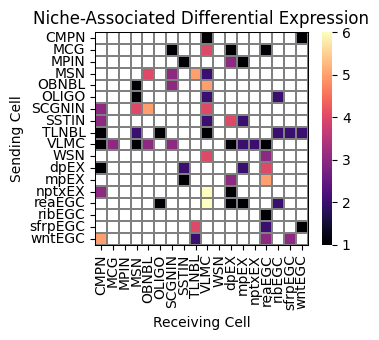

In [38]:
niche_interp.type_coupling(
    cmap="magma", 
    figsize=(4.4, 3.5),    
    save_show_or_return = 'return')

### Niche model result 2:

Sender effect: selecting reaEGC as the sender cell and visualizing effects on target genes in receiver cell types (all of the
other cell types in the system). Visualization will plot the effect size, but qvals can be visualized using `plot_mode'="qvals"`.

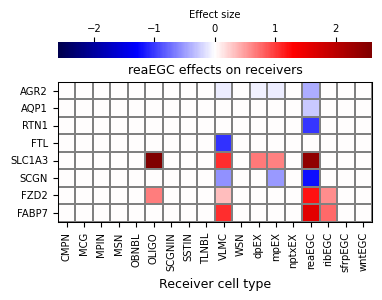

In [46]:
niche_interp.sender_effect_on_all_receivers(
    sender='reaEGC',
    figsize=(4.4, 5),
    save_show_or_return = 'return',
)

### Niche model result 3:

Receiver effect: selecting reaEGC as the receiver cell, visualizing effects on target genes in reaEGC with all other cell types in the system as the sender. Visualization will plot the effect size, but qvals can be visualized using `'plot_mode'="qvals"`.

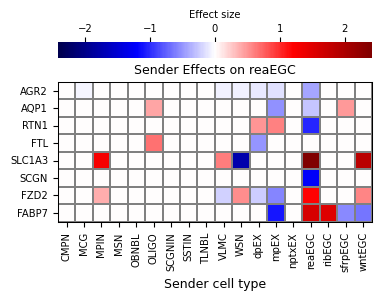

In [45]:
niche_interp.all_senders_effect_on_receiver(
    receiver='reaEGC',
    figsize=(4.4, 5),
    save_show_or_return="return",
)

## Niche lr model 

to predict a model for spatially-aware regression using the prevalence of and connections between categories within spatial neighborhoods and the cell type-specific expression of ligands and receptors to predict the regression target.

we choose the ligand-receptor pairs results based on the `./3.cci/1_cell-cell_communication_inference.ipynb`. (In our case, we use ligand "L1CAM", "PTN", "TNC",and receptor "ERBB3", "SDC1", and target genes above.)

First, we fit the Niche lr model, it is worth noting that `cci_dir` is the name of the directory containing `human_mouse_signaling_network.csv`. (Here, we provide species are `human`,`mouse`,`axolotl` to do below analysis). Other parameters are similar to `st.tl.Niche_Model`.

In [75]:
niche_lr_interp = st.tl.Niche_LR_Model(
    adata = adata,
    group_key='Annotation',
    genes = adata.var_names,
    smooth=False,
    normalize=False,
    log_transform=False,
    weights_mode="knn",
    niche_lr_r_lag=False,
    lig=["L1CAM", "PTN", "TNC"],
    rec=["ERBB3", "SDC1"],
    species="axolotl",
    data_id="axolotl",
    distr="poisson",
    cci_dir="/DATA/User/zuolulu/test/spateo-release/spateo/tools/database"
)

|-----> Note: argument provided to 'genes' represents the dependent variables for non-ligand-based analysis, but are used as independent variables for ligand-based analysis.
|-----> Predictor arrays for :class `Niche_LR_Model` are extremely sparse. It is recommended to provide categories to subset for :func `GLMCV_fit_predict`.
|-----> Preparing data: converting categories to one-hot labels for all samples.
|-----> Checking for pre-computed adjacency matrix for dataset axolotl...
|-----> Adjacency matrix loaded from file.
|-----> Preparing data: converting categories to one-hot labels for all samples.
|-----? Length of the provided list of ligands (input to 'l') does not match the length of the provided list of receptors (input to 'r'). This is fine, so long as all ligands and all receptors have at least one match in the other list.
Setting up Niche-L:R model using the following ligand-receptor pairs: [('L1CAM', 'ERBB3'), ('PTN', 'SDC1'), ('TNC', 'SDC1')]
|-----> Starting from 3 ligand

In [76]:
nlr_coeffs, _ = niche_lr_interp.GLMCV_fit_predict(
    cat_key='Annotation', 
    categories=['reaEGC', 'WSN'],                    
    reg_lambda=np.logspace(np.log(1e-3), np.log(1e-5), 3, base=np.exp(1)),
    n_jobs=1,
)

|-----> Optimal lambda regularization value for HSP90B1: 0.0010000000000000007.
|-----> Optimal lambda regularization value for KRAS: 0.0010000000000000007.
|-----> Optimal lambda regularization value for CTNNB1: 0.0010000000000000007.
|-----> Optimal lambda regularization value for HIF1A: 1.0000000000000004e-05.
|-----> Optimal lambda regularization value for PIK3R3: 0.0010000000000000007.
|-----> Optimal lambda regularization value for PLCG2: 1.0000000000000004e-05.
|-----> Optimal lambda regularization value for CAV1: 0.0010000000000000007.
|-----> Optimal lambda regularization value for CAV2: 0.0010000000000000007.
|-----> Optimal lambda regularization value for SHC2: 1.0000000000000004e-05.
|-----> Optimal lambda regularization value for NRAS: 0.0010000000000000007.
|-----> Optimal lambda regularization value for PIK3CA: 1.0000000000000004e-05.
|-----> Optimal lambda regularization value for SHC3: 0.0010000000000000007.
|-----> Optimal lambda regularization value for PIK3R1: 0.001

In [ ]:
nlr_coeffs.to_csv(os.path.join(save_dir, 'nlr_coeffs.csv'))
nlr_df = pd.read_csv(os.path.join(save_dir, 'nlr_coeffs.csv'),index_col=0)
nlr_df

Finally, we show the results of the niche lr model.

### Niche lr model result 1:

Heatmap for coefficients:

We can choose specific sender-receiver pairs for the plot (recommended, otherwise plot will probably be large to the point of being uninterpretable), zero_center_cmap sets the colormap's median color intensity to 0. Coefficients absolute value larger or smaller than mask_threshold are not assigned color in plot.

In [79]:
subset_cols=["reaEGC-WSN", "WSN-reaEGC"]

0.5078398069446302


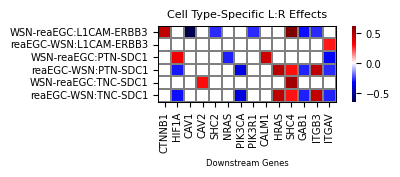

In [87]:
niche_lr_interp.visualize_params(
    nlr_df, 
    subset_cols=subset_cols if subset_cols is not None else None, 
    cmap='seismic', 
    zero_center_cmap=True,                                
    transpose=True, 
    title="Cell Type-Specific L:R Effects", 
    mask_threshold=0.25,
    xlabel="Downstream Genes", 
    figsize=(5, 1), 
    save_show_or_return='return',     
    )